In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist  
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import time

Загрузим датасет из базы данных рукописных цифр MNIST:

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Каждое изображения имеет разрешение 28x28 пикселей и представлено в черной-белом цвете.

(28, 28)


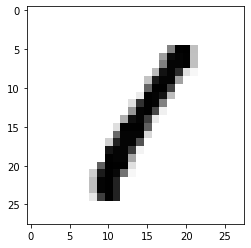

In [4]:
#рассмотрим пример такого изображения
plt.imshow(train_images[3], cmap=plt.cm.binary)
print(train_images[3].shape)

Нейронная сеть гораздо быстрее работает со значениями, находящимися в диапазоне от 0 до 1, поэтому стандартизируем наши данные, чтобы наибольшее значение было равно 1:

In [5]:
#стандартизируем входные данные
train_images = train_images / 255
test_images = test_images / 255

Преобразуем лейблы наших изображений в векторы размерности 10x1. Для i+1 лейбла вектор выглядит следующим образом: на i позиции стоит 1, а на всех остальных - 0.

In [6]:
train_labels_cat = keras.utils.to_categorical(train_labels, 10)
test_labels_cat = keras.utils.to_categorical(test_labels, 10)

In [7]:
#рассмотрим пример 
print(train_labels[3])
print(train_labels_cat[3])
print(train_labels_cat[3].shape)

1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(10,)


На вход сверточному слою нейросети подается тезор размерности 4, поэтому нам необходимо к нашей обучающей и тестовой выборке добавить одну размерность:

In [8]:
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

Используя метод Sequential из библиотеки keras, создаем модель нашей нейросети. Она состоит из семи слоев, пять из которых скрытые. 
Первые четыре слоя - сверточные, последующие три слоя составляют простейшую полносвязную нейросеть, в которую передается вектор размерностью 3. 
По концепции сверточных нейронных сетей: каждый последующий слой должен укрупнять масштаб полученных признаков, поэтому после сверточного слоя Conv2D идет слой MaxPooling2D, который выбирает максимальные значения из квадратов, выбранного размера, уменьшая карту признаков.

In [9]:
model = keras.Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10,  activation='softmax')
])

Так как наша задача состоит в классификации изображений более чем на 2 класса, а также функция softmax является функцией активации для выходного слоя, в качестве критерия качества мы будем использовать категориальную кроссэнтропию.

In [10]:
model.compile(optimizer='adam', 
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

Начнем обучение нашей модели на тренировочных данных. В датасете из библиотеки MNIST 60, 000 изображений составляют обучающую выборку. Мы разделим эту выборку на два класса - непосредственно обучающую выборку и выборку валидации, которая будет составлять 20% от общего объема обучающей выборки (12, 000 изображений).

In [11]:
t=time.time()
fit = model.fit(train_images, train_labels_cat, batch_size=32, epochs=5, validation_split = 0.2)
t = time.time() - t

print("Время обучения модели: ", t, "с")

Epoch 1/5
1500/1500 [==============================] - 60s 40ms/step - loss: 0.1405 - accuracy: 0.9567 - val_loss: 0.0678 - val_accuracy: 0.9799
Epoch 2/5
1500/1500 [==============================] - 60s 40ms/step - loss: 0.0448 - accuracy: 0.9859 - val_loss: 0.0444 - val_accuracy: 0.9872
Epoch 3/5
1500/1500 [==============================] - 59s 40ms/step - loss: 0.0307 - accuracy: 0.9900 - val_loss: 0.0483 - val_accuracy: 0.9854
Epoch 4/5
1500/1500 [==============================] - 59s 40ms/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.0368 - val_accuracy: 0.9902
Epoch 5/5
1500/1500 [==============================] - 60s 40ms/step - loss: 0.0149 - accuracy: 0.9949 - val_loss: 0.0386 - val_accuracy: 0.9893
Время обучения модели:  300.1879172325134 с


Оценим работу нашей модели на тестовой выборке (она составляет 10, 000 изображений):

In [12]:
eval = model.evaluate(test_images, test_labels_cat)

313/313 [==============================] - 4s 12ms/step - loss: 0.0299 - accuracy: 0.9902


In [13]:
print("Точность: {}%".format(round(eval[1]*100,4)))

Точность: 99.02%


Построим графики точности и потерь на каждой итерации:



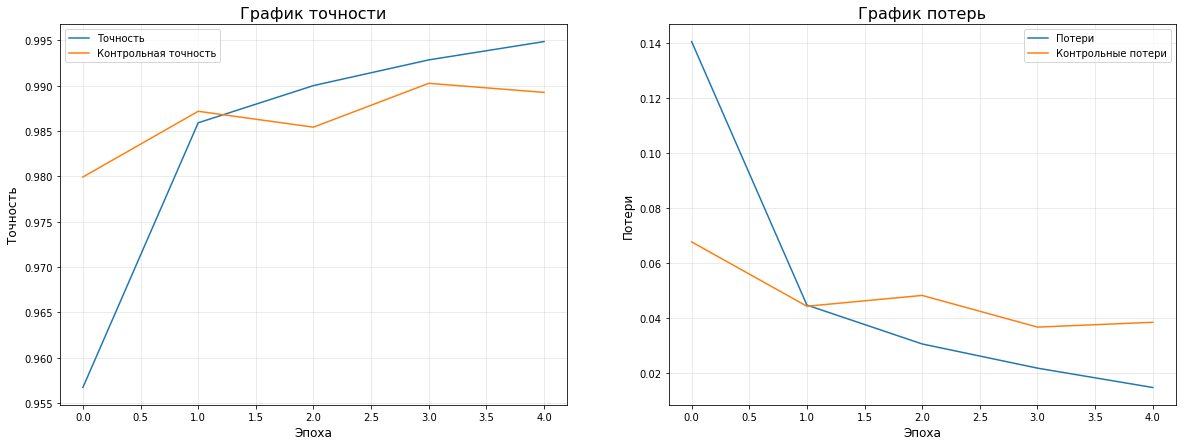

In [14]:
f = plt.figure(figsize=(20,7))

 
f.add_subplot(121)

plt.plot(fit.epoch, fit.history['accuracy'], label = "Точность") 
plt.plot(fit.epoch, fit.history['val_accuracy'], label = "Контрольная точность")  

plt.title("График точности", fontsize=16)
plt.xlabel("Эпоха", fontsize=12)
plt.ylabel("Точность", fontsize=12)
plt.grid(alpha = 0.3)
plt.legend()

 
f.add_subplot(122)

plt.plot(fit.epoch, fit.history['loss'], label = "Потери") 
plt.plot(fit.epoch, fit.history['val_loss'], label = "Контрольные потери") 
plt.title("График потерь", fontsize=16)
plt.xlabel("Эпоха", fontsize=12)
plt.ylabel("Потери", fontsize=12)
plt.grid(alpha = 0.3)
plt.legend()

plt.show()

In [15]:
files.upload()

Saving 0.jpg to 0.jpg
Saving 1.jpg to 1.jpg
Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg
Saving 5.jpg to 5.jpg
Saving 6.jpg to 6.jpg
Saving 7.jpg to 7.jpg
Saving 8.jpg to 8.jpg
Saving 9.jpg to 9.jpg


{'0.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe1\x00"Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x01\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x02\x01\x01\x02\x02\x02\x02\x02\x02\x02\x02\x03\x05\x03\x03\x03\x03\x03\x06\x04\x04\x03\x05\x07\x06\x07\x07\x07\x06\x07\x07\x08\t\x0b\t\x08\x08\n\x08\x07\x07\n\r\n\n\x0b\x0c\x0c\x0c\x0c\x07\t\x0e\x0f\r\x0c\x0e\x0b\x0c\x0c\x0c\xff\xdb\x00C\x01\x02\x02\x02\x03\x03\x03\x06\x03\x03\x06\x0c\x08\x07\x08\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\xff\xc0\x00\x11\x08\x00\x1c\x00\x1c\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\

Проверим работу нашей нейронной сети на изображениях, которые не участвовали в обучении, и определим ее точность:

[]

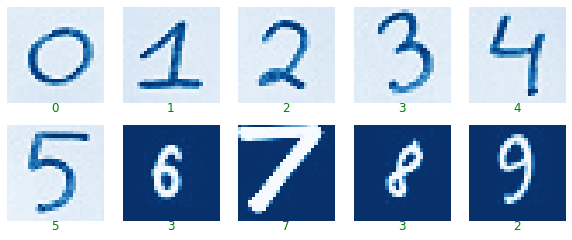

In [27]:
correct = 0

wrong_img = []
wrong_labels = []

rows = 2
cols = 5

f = plt.figure(figsize=(2*cols, 2*rows))

for i in range(rows * cols): 
    img = load_img(f'{i}.jpg')
    img_array = img_to_array(img)
    img_array = img_array / 255
    img_array = img_array[:,:,:1].reshape([1,28,28,1])
    pred = np.argmax(model.predict(img_array), axis = 1)[0]
    
    f.add_subplot(rows,cols,i+1)
    img_array=img_array.reshape([28,28])
    plt.imshow(img_array, cmap="Blues") 
    plt.axis("off")
    plt.title("{}".format(pred), y=-0.15, color="green")

    if i == pred:
      correct += 1

    if i != pred:
      wrong_img.append(img_array)
      wrong_labels.append(pred)

plt.plot()

In [17]:
print("Точность распознавания изображений не участвовавших в обучении: ", (correct / 10)*100, "%")

Точность распознавания изображений не участвовавших в обучении:  70.0 %


Выведем изображения цифр, которые нейросеть распознала неверно:

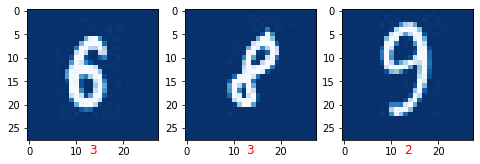

In [28]:
f = plt.figure(figsize=(8, 4))

n = 10 - correct

for i in range(n):
  f.add_subplot(1,n,i+1)
  plt.imshow(wrong_img[i], cmap="Blues") 
  plt.title("{}".format(wrong_labels[i]), y=-0.15, color="red")

Сохраним нашу модель:

In [29]:
model.save('model.h5')